# Compute on GPU: Cupy Vectors and Operators

@Author: Francesco Picetti - picettifrancesco@gmail.com

In this notebook we will show how to define a new `vector` class based on [Cupy](https://cupy.chainer.org/) operations.

First we need to install `cupy` properly for our CUDA version. See its [guide](https://docs.cupy.dev/en/stable/install.html).

1. `pip install cupy-cuda111` (change the version!
2. `conda install -c rapidsai cusignal` (for operators)

#### Import modules

In [1]:
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

**Note**: as the vector is instantiated on a GPU, we use the method `plot` for getting a plottable array

In [2]:
x = o.VectorCupy(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32),
                 device=0).scale(1 / 255.)
print(x.deviceName)

GPU 0 - Tesla V100-PCIE-16GB


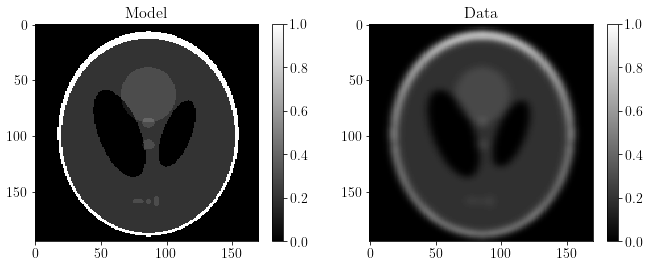

In [3]:
G = o.GaussianFilter(x, (3, 3))
d = G * x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('Model')
plt.imshow(x.plot(), cmap='gray', vmin=0, vmax=1), plt.colorbar()
plt.subplot(122), plt.title('Data')
plt.imshow(d.plot(), cmap='gray', vmin=0, vmax=1), plt.colorbar()
plt.show()

As regularizer, we compute the gradient. If you need some signal processing operations, check out [cuSIGNAL](https://github.com/rapidsai/cusignal).

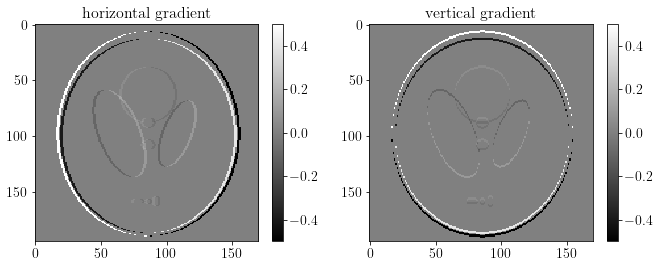

In [4]:
D = o.Gradient(x)
Dx = D * x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('horizontal gradient')
plt.imshow(Dx.vecs[1].plot(), cmap='gray'), plt.colorbar()
plt.subplot(122), plt.title('vertical gradient')
plt.imshow(Dx.vecs[0].plot(), cmap='gray'), plt.colorbar()
plt.show()

Problem and solver:

In [5]:
problemSB = o.GeneralizedLasso(x.clone().zero(), d, G, reg=D, eps=1e-3)
SB = o.SplitBregman(o.BasicStopper(niter=200), niter_inner=3, niter_solver=10,
                    linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
SB.run(problemSB, verbose=True, inner_verbose=False)

##########################################################################################
            SPLIT-BREGMAN Solver
    Restart folder: /tmp/restart_2022-04-22T01-47-39.563843/
    Inner iterations: 3
    Solver iterations: 10
    L1 Regularizer weight: 1.00e-03
    Bregman update weight: 1.00e+00
    Using warm start option for inner problem
##########################################################################################

iter = 000, obj = 6.57986e+02, df_obj = 6.58e+02, reg_obj = 0.00e+00, rnorm = 3.63e+01
iter = 001, obj = 1.56466e+00, df_obj = 2.16e-02, reg_obj = 1.54e+00, rnorm = 1.26e+01
iter = 002, obj = 1.59651e+00, df_obj = 7.26e-03, reg_obj = 1.59e+00, rnorm = 1.33e+01
iter = 003, obj = 1.60710e+00, df_obj = 4.03e-03, reg_obj = 1.60e+00, rnorm = 1.37e+01
iter = 004, obj = 1.61852e+00, df_obj = 2.70e-03, reg_obj = 1.62e+00, rnorm = 1.39e+01
iter = 005, obj = 1.62172e+00, df_obj = 1.99e-03, reg_obj = 1.62e+00, rnorm = 1.41e+01
iter = 006, obj = 1.62525e+00, df

iter = 090, obj = 1.39301e+00, df_obj = 7.89e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 091, obj = 1.39157e+00, df_obj = 7.82e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 092, obj = 1.39018e+00, df_obj = 7.75e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 093, obj = 1.38877e+00, df_obj = 7.69e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 094, obj = 1.38740e+00, df_obj = 7.63e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 095, obj = 1.38603e+00, df_obj = 7.57e-05, reg_obj = 1.39e+00, rnorm = 1.60e+01
iter = 096, obj = 1.38469e+00, df_obj = 7.51e-05, reg_obj = 1.38e+00, rnorm = 1.61e+01
iter = 097, obj = 1.38336e+00, df_obj = 7.45e-05, reg_obj = 1.38e+00, rnorm = 1.61e+01
iter = 098, obj = 1.38207e+00, df_obj = 7.39e-05, reg_obj = 1.38e+00, rnorm = 1.61e+01
iter = 099, obj = 1.38077e+00, df_obj = 7.34e-05, reg_obj = 1.38e+00, rnorm = 1.61e+01
iter = 100, obj = 1.37952e+00, df_obj = 7.28e-05, reg_obj = 1.38e+00, rnorm = 1.61e+01
iter = 101, obj = 1.37826e+00, df_obj = 7.2

iter = 186, obj = 1.31068e+00, df_obj = 4.71e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 187, obj = 1.31014e+00, df_obj = 4.70e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 188, obj = 1.30968e+00, df_obj = 4.68e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 189, obj = 1.30916e+00, df_obj = 4.67e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 190, obj = 1.30870e+00, df_obj = 4.65e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 191, obj = 1.30818e+00, df_obj = 4.64e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 192, obj = 1.30773e+00, df_obj = 4.62e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 193, obj = 1.30722e+00, df_obj = 4.60e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 194, obj = 1.30677e+00, df_obj = 4.59e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 195, obj = 1.30627e+00, df_obj = 4.57e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 196, obj = 1.30583e+00, df_obj = 4.56e-05, reg_obj = 1.31e+00, rnorm = 1.68e+01
iter = 197, obj = 1.30533e+00, df_obj = 4.5

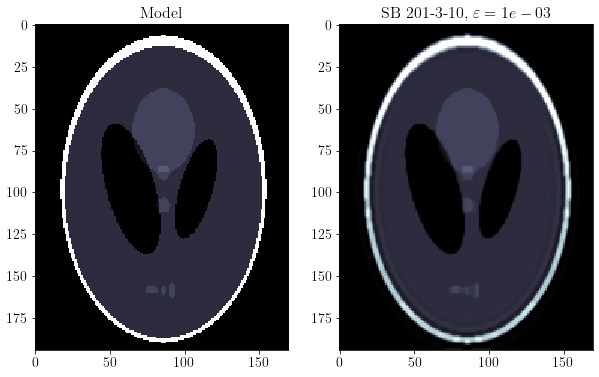

In [6]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(problemSB.model.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title(r'SB %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

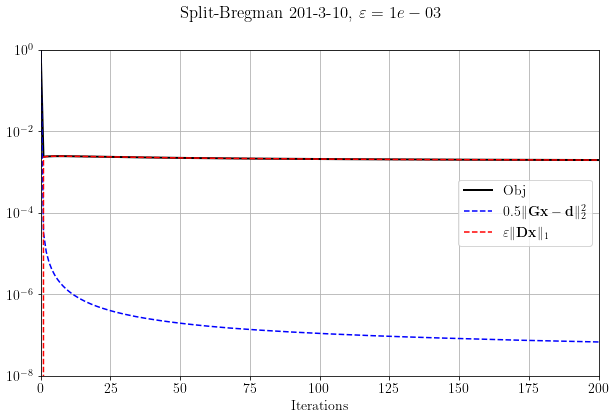

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
ax.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
ax.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\varepsilon \Vert \mathbf{Dx}\Vert_1$")
ax.set_ylim(1e-8, 1), ax.set_xlim(0, SB.stopper.niter)
ax.set_xlabel("Iterations")
ax.legend(loc="right")
ax.grid(True)
plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()